# **Proyek Akhir : Image Classification Model Deployment**
### Nama : Thariq Iskandar Zulkarnain M P
### No. Pendaftaran : 0182180151-57
### Email : thariqiskandar9@gmail.com
### No. Handphone : 6281332409623
### Tema Pelatihan : FGA Machine Learning (IBM)

# Import Library

In [21]:
import os
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Input Data dari Kaggle
### Dataset : Animal Faces
### Link : https://www.kaggle.com/andrewmvd/animal-faces 

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thariqiskandarzmp","key":"747e02d80ab399173c143f6694cb9ba1"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d andrewmvd/animal-faces

 99% 688M/696M [00:05<00:00, 129MB/s]
100% 696M/696M [00:05<00:00, 136MB/s]


In [7]:
!unzip -q animal-faces.zip -d .

# Pembaharuan Jumlah Data Train dan Validation Sesuai Ratio

### Menghitung jumlah data train dan validation saat ini

In [10]:
# Mendefinisikan variabel yang diperlukan
train_dir = '/content/afhq/train'
val_dir = '/content/afhq/val'
data_label = os.listdir(train_dir)
class_total = len(data_label)

train_label_dir = []
val_label_dir = []
train_label_data = []
val_label_data = []

for i in range(class_total):
  # menyimpan path direktori setiap label dari data train dan validation
  train_label_dir.append(os.path.join(train_dir, data_label[i]))
  val_label_dir.append(os.path.join(val_dir, data_label[i]))
  
  # menyimpan keseluruhan data dari data train dan validation
  for x in os.listdir(train_label_dir[i]):
    train_label_data.append(x)
  for y in os.listdir(val_label_dir[i]):
    val_label_data.append(y)

train_total = len(train_label_data)
val_total = len(val_label_data)

print('Jumlah data train saat ini :', train_total)
print('Jumalh data validation saat ini :', val_total)

Jumlah data train saat ini : 14630
Jumalh data validation saat ini : 1500


### Menghitung jumlah data yang harus dipindahkan dari data train ke data validation

In [11]:
correct_total_val_data = 0.2*(train_total + val_total)
print('Jumlah data validation seharusnya(20%) :', correct_total_val_data)

lack_val_data = (correct_total_val_data - val_total)
print('Jumlah data yang harus dipindahkan dari data train :', lack_val_data)

percentage_from_train_data = (lack_val_data / train_total)
print('Persentase yang diperlukan dari train data untuk menambah val data :', percentage_from_train_data)

Jumlah data validation seharusnya(20%) : 3226.0
Jumlah data yang harus dipindahkan dari data train : 1726.0
Persentase yang diperlukan dari train data untuk menambah val data : 0.11797676008202324


### Memecah data train untuk dipindahkan ke data validation

In [12]:
# Mendefinisikan variabel yang diperlukan
train_data = []
val_data = []
sum_train = 0
sum_val = 0

for i in range(class_total):
  train = []
  val = []

  # memecah data train dari setiap label dengan persentase yang telah diperoleh
  train, val = train_test_split(os.listdir(train_label_dir[i]), test_size = percentage_from_train_data)
  train_data.append(train)
  val_data.append(val)

  # jumlah total data train baru dan data validation yang akan dipindah
  sum_train += len(train_data[i])
  sum_val += len(val_data[i])

print('Jumlah train data baru : ' + str(sum_train))
print('Jumlah validation data yang akan dipindahkan : ' + str(sum_val))

Jumlah train data baru : 12903
Jumlah validation data yang akan dipindahkan : 1727


### Memindahkan data validation baru ke direktori data validation lama

In [13]:
new_sum_val = 0
for i in range(class_total):
  for x in val_data[i]:
    shutil.move(os.path.join(train_label_dir[i], x), os.path.join(val_label_dir[i], x))
  new_sum_val += len(os.listdir(val_label_dir[i]))
print('Jumlah data validation yang baru :', new_sum_val)

Jumlah data validation yang baru : 3227


Jumlah data validation sudah sesuai harapan, hanya berbeda 1 data saja dari perhitungan yang telah dilakukan sebelumnya

# Data Preprocessing

In [14]:
# membuat sebuah objek ImageDataGenerator untuk data train dan validation
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    zoom_range=0.2,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# mempersiapkan data train dan validation yang akan dipelajari oleh model menggunakan objek image data generator sebelumnya
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical') # menggunakan class_mode = 'categorical' karena kasus lebih dari 2 kelas

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32, 
        class_mode='categorical') # menggunakan class_mode = 'categorical' karena kasus lebih dari 2 kelas

Found 12903 images belonging to 3 classes.
Found 3227 images belonging to 3 classes.


# Model Convolutional Neural Network

In [16]:
#membuat kelas callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi training set dan validation set telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [17]:
# membuat arsitektur CNN
model = tf.keras.models.Sequential([
    # input shape adalah ukuran gambar yang diinginkan 150x150 dengan warna 3 byte
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    # Ratakan hasil untuk dimasukkan ke dalam DNN
    tf.keras.layers.Flatten(), 
    # hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # output layer
    tf.keras.layers.Dense(3, activation='softmax')  # dataset terdiri dari 3 kelas
])

In [18]:
# compile model dengan optimizer 'adam' dan loss function 'categorical_crossentropy'
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# latih model
history = model.fit(
      train_generator,
      batch_size=128,
      steps_per_epoch=100,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      callbacks=[callbacks],
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30
100/100 - 154s - loss: 1.1145 - accuracy: 0.3525 - val_loss: 1.0710 - val_accuracy: 0.3562
Epoch 2/30
100/100 - 152s - loss: 0.9235 - accuracy: 0.5478 - val_loss: 0.5263 - val_accuracy: 0.8062
Epoch 3/30
100/100 - 153s - loss: 0.5876 - accuracy: 0.7681 - val_loss: 0.5482 - val_accuracy: 0.7437
Epoch 4/30
100/100 - 151s - loss: 0.4475 - accuracy: 0.8277 - val_loss: 0.3905 - val_accuracy: 0.8188
Epoch 5/30
100/100 - 152s - loss: 0.4744 - accuracy: 0.8069 - val_loss: 0.4237 - val_accuracy: 0.8500
Epoch 6/30
100/100 - 152s - loss: 0.3714 - accuracy: 0.8597 - val_loss: 0.3256 - val_accuracy: 0.9000
Epoch 7/30
100/100 - 152s - loss: 0.3486 - accuracy: 0.8675 - val_loss: 0.2845 - val_accuracy: 0.8750
Epoch 8/30
100/100 - 151s - loss: 0.2786 - accuracy: 0.8976 - val_loss: 0.3052 - val_accuracy: 0.8938
Epoch 9/30
100/100 - 152s - loss: 0.2942 - accuracy: 0.8878 - val_loss: 0.2065 - val_accuracy: 0.9375
Epoch 10/30
100/100 - 150s - loss: 0.2862 - accuracy: 0.8932 - val_loss: 0.2899 - 

# Plot Loss & Accuracy

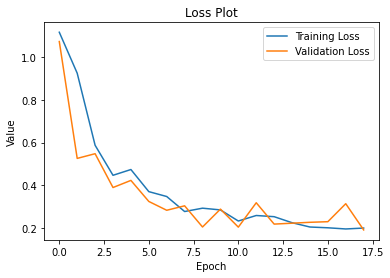

In [22]:
#plot train & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

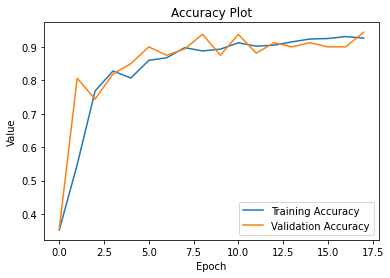

In [23]:
#plot train & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

# Simpan Model ke Dalam Format TF-Lite

In [24]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('AF_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpe1vg7db8/assets
